# Objectifs du TP 2 : ACP fonctionnelle

- ACP des données "Canadian weather" avec les différentes approches vues en cours :
    - directement sur les vecteurs de données
    - en approchant chaque donnée par une B-spline sur une grille commune, puis en faisant une ACP classique
    - en développant une ACP dans une base de fonctions
- Même objectifs pour des données "destructurées" (i.e. numération des CD4)

Pour cela, nous allons principalement utiliser deux packages python: ```skfda``` et ```scipy```.

In [1]:
from skfda import datasets
import matplotlib.pyplot as plt
import numpy as np

### Chargement des données de températures du Canada

Nous allons en premier lieu manipuler le jeu de données "Canadian weather" issu du package skfda.

In [2]:
tableau, cat = datasets.fetch_weather(return_X_y=True, as_frame=True)
fd = tableau.iloc[:, 0].values
fd_temperatures = fd.coordinates[0] 


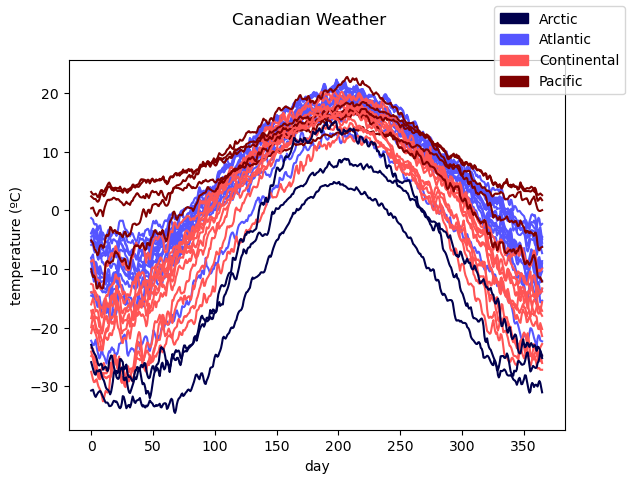

In [3]:
colormap = plt.colormaps['seismic']
label_names = cat.values.categories
nlabels = len(label_names)
label_colors = colormap(np.arange(nlabels) / (nlabels - 1))
label_cat = cat.values.codes

fd_temperatures.plot(group=label_cat, group_colors=label_colors,group_names=label_names)
plt.show()

## ACP classique

**Exercice:**
- effectuer une ACP classique sur les données en considérant chaque "courbe" comme un vecteur de taille 365.
- tracer les deux premières composantes principales.
- tracer les projections des données sur les deux premières composantes principales.

In [4]:
import scipy.linalg as la

n = 35
data = np.reshape(fd_temperatures.data_matrix, (n,365))
t = np.reshape(fd_temperatures.grid_points, (365))

data_mean = np.mean(data,0)
X = data-data_mean


cov_X = np.dot(X.T,X)/np.size(X,0) # covariance matrix
eigVals_cov, eig_cov = la.eig(cov_X) # perform euclidean PCA
eigVals_cov = np.diag(eigVals_cov.real)
eig_cov = eig_cov.real
proj_cov = np.dot(X,eig_cov)

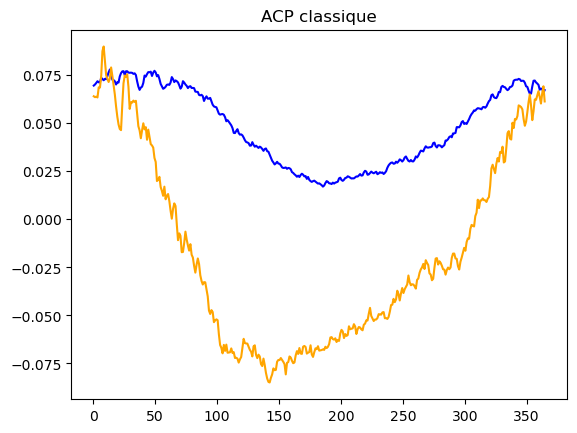

In [5]:
## Plot des deux premières composantes

plt.plot(t, eig_cov[:,0], label = '1ère composante', color = 'blue')
plt.plot(t, eig_cov[:,1], label = '2ème composante', color = 'orange')
plt.title('ACP classique')
plt.show()

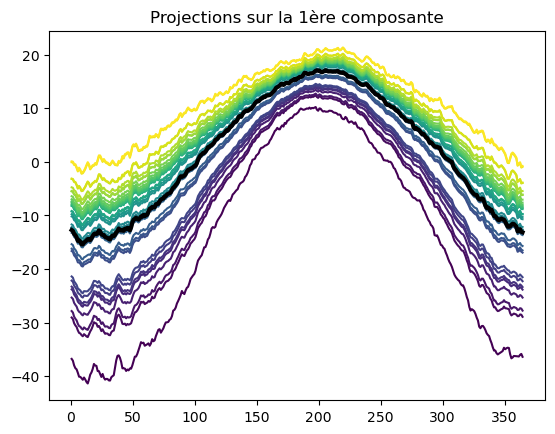

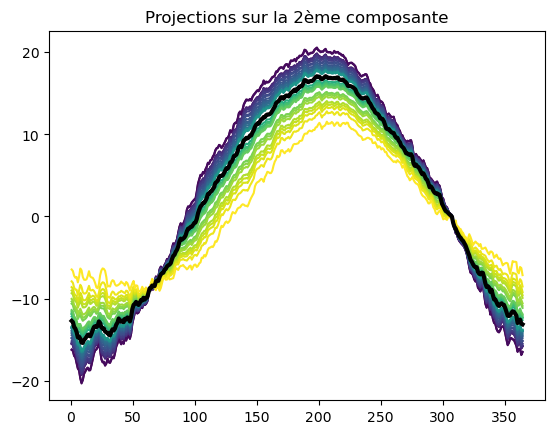

In [6]:
## Plot des projections des données sur les deux premières composantes


import matplotlib
map1 = matplotlib.colormaps['viridis'].resampled(n)

## Première composante
euc1 = np.zeros((n,len(t))) 
I1 = np.argsort(proj_cov[:,0])
for i in np.arange(n):
    euc1[i,:] = data_mean + proj_cov[I1[i],0]*eig_cov[:,0]
    plt.plot(t,euc1[i,:],color = map1(i))
plt.plot(t,data_mean,linewidth= 3, color = 'black')
plt.title('Projections sur la 1ère composante')
plt.show()

## Deuxième composante
euc2 = np.zeros((n,len(t))) 
I2 = np.argsort(proj_cov[:,1])
for i in np.arange(n):
    euc2[i,:] = data_mean + proj_cov[I2[i],1]*eig_cov[:,1]
    plt.plot(t,euc2[i,:],color = map1(i))
plt.plot(t,data_mean,linewidth= 3, color = 'black')
plt.title('Projections sur la 2ème composante')
plt.show()


## ACP classique sur les données lissées

**Exercice:**
- approcher chacun des vecteurs par une B-spline de degré 3
- interpoler ces splines sur $t_{\text{interp}} = [0,0.5,1,1.5,\ldots,364,364.5, 365]$
- effectuer une ACP classique sur ces nouveaux vecteurs (de plus grande dimension)
- tracer les deux premières composantes principales
- tracer les projections des données sur les deux premières composantes principales.

Pour représenter les données dans une base B-spline cubique (de degré 3), utiliser les fonctions ```splrep``` et ```BSpline```du package scipy.interpolate, avec un paramètre de régularisation $s=50$.

In [7]:
## Approximation des vecteurs de données par B-spline de degré 3 et interpolation de ces splines sur t_interp

from scipy.interpolate import splrep
from scipy.interpolate import BSpline

t_interp = np.arange(0, 364.5, 0.5)
data_lisse = np.zeros((n,len(t_interp)))

for i in np.arange(n):
    knots, coeff, _ = splrep(t, data[i,:], k = 3, s = 50)
    B = BSpline(knots, coeff, 3)
    data_lisse[i,:] = B(t_interp)

In [8]:
## ACP sur "vecteurs régularisés"

data_mean_lisse = np.mean(data_lisse,0)
X_lisse = data_lisse-data_mean_lisse

cov_X_lisse = np.dot(X_lisse.T,X_lisse)/np.size(X_lisse,0) # covariance matrix
eigVals_cov_lisse, eig_cov_lisse = la.eig(cov_X_lisse) # perform euclidean PCA
eigVals_cov_lisse = np.diag(eigVals_cov_lisse.real)
eig_cov_lisse = eig_cov_lisse.real
proj_cov_lisse = np.dot(X_lisse,eig_cov_lisse)

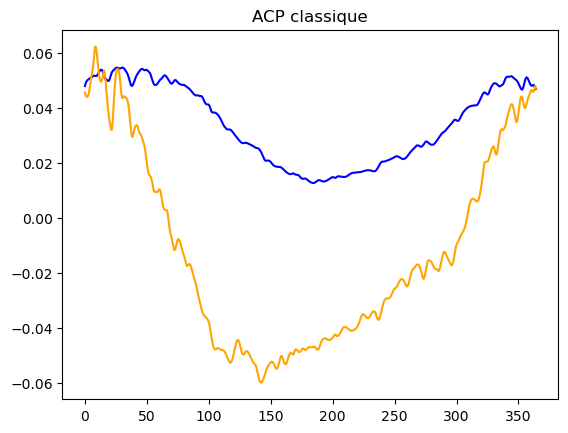

In [9]:
## Plot des deux premières composantes

plt.plot(t_interp, eig_cov_lisse[:,0], label = '1ère composante', color = 'blue')
plt.plot(t_interp, eig_cov_lisse[:,1], label = '2ème composante', color = 'orange')
plt.title('ACP classique')
plt.show()

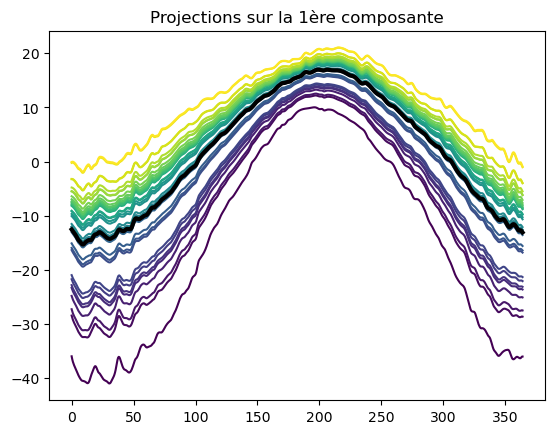

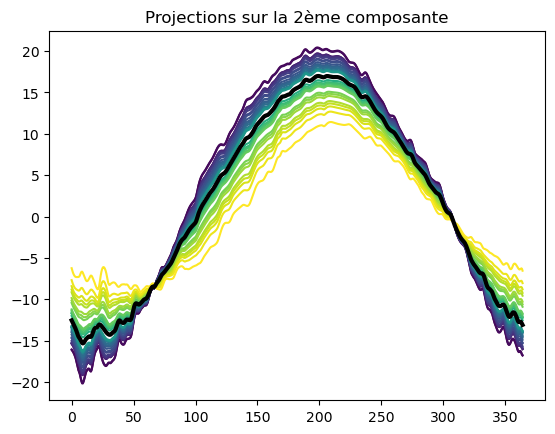

In [10]:
## Plot des projections des données sur les deux premières composantes

## Première composante
euc1_lisse = np.zeros((n,len(t_interp))) 
I1 = np.argsort(proj_cov_lisse[:,0])
for i in np.arange(n):
    euc1_lisse[i,:] = data_mean_lisse + proj_cov_lisse[I1[i],0]*eig_cov_lisse[:,0]
    plt.plot(t_interp,euc1_lisse[i,:],color = map1(i))
plt.plot(t_interp,data_mean_lisse,linewidth= 3, color = 'black')
plt.title('Projections sur la 1ère composante')
plt.show()

## Deuxième composante
euc2_lisse = np.zeros((n,len(t_interp)))
I2 = np.argsort(proj_cov_lisse[:,1])
for i in np.arange(n):
    euc2_lisse[i,:] = data_mean_lisse + proj_cov_lisse[I2[i],1]*eig_cov_lisse[:,1]
    plt.plot(t_interp,euc2_lisse[i,:],color = map1(i))
plt.plot(t_interp,data_mean_lisse,linewidth= 3, color = 'black')
plt.title('Projections sur la 2ème composante')
plt.show()


**Exercice:** Comparer sur une même figure:
- les composantes principales par l'ACP classique, régularisées a posteriori par Bspline (et interpolées sur $t_{\text{interp}}$)
- les composantes principales obtenues après approximations par Bspline des vecteurs de données

In [11]:
## Approximation par Bspline des deux premières composantes principales obtenues par l'ACP classique

k1, c1, _ = splrep(t, eig_cov[:,0], k = 3)
B1 = BSpline(k1, c1, 3)
acp_classique_Bspline1 = B1(t_interp)

k2, c2, _ = splrep(t, eig_cov[:,1], k = 3)
B2 = BSpline(k2, c2, 3)
acp_classique_Bspline2 = B2(t_interp)


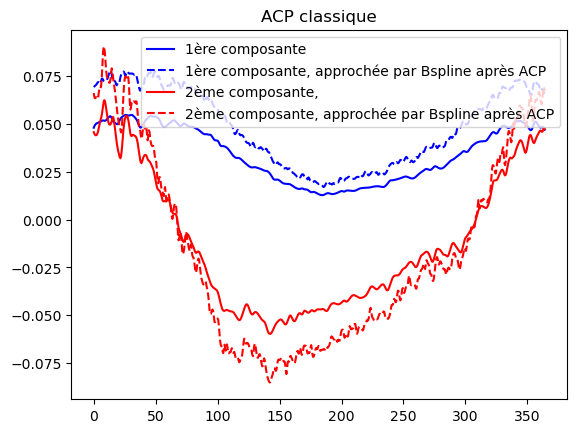

In [12]:
## Comparaison des composantes principales lissées par Bspline après ACP et des composantes principales obtenues
# en ayant lisser les données avant l'ACP.


plt.plot(t_interp, eig_cov_lisse[:,0], label = '1ère composante', color = 'blue')
plt.plot(t_interp, acp_classique_Bspline1, 'b--', label = '1ère composante, approchée par Bspline après ACP')

plt.plot(t_interp, eig_cov_lisse[:,1], label = '2ème composante, ', color = 'red')
plt.plot(t_interp, acp_classique_Bspline2, 'r--', label = '2ème composante, approchée par Bspline après ACP')

plt.title('ACP classique')
plt.legend()
plt.show()

**Question:** Que comprenez-vous?

# ACP sur une base de fonctions Bspline : méthode utilisant skfda

In [13]:
from skfda.representation.basis import BSplineBasis
basis = BSplineBasis(n_basis = 70, order = 4)

basis_fd = fd_temperatures.to_basis(basis)


**Exercice:** Via la fonction ```FPCA``` du package ```skfda```, récupérer les deux premières composantes principales obtenues par ACP dans une base de fonctions, et les plotter.

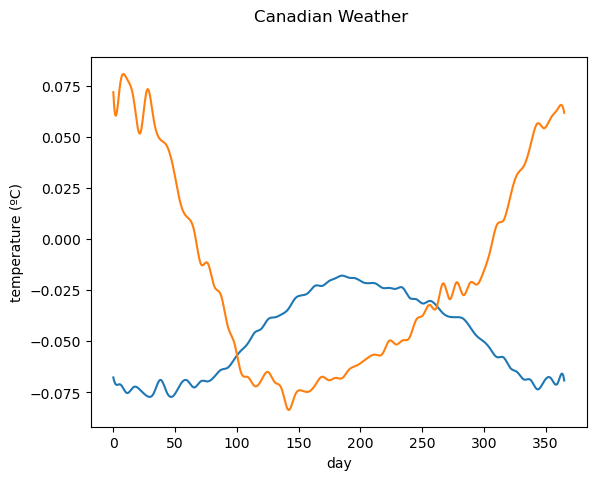

In [14]:
from skfda.preprocessing.dim_reduction import FPCA

fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()
plt.show()


**Exercice:** Comparer les 3 méthodes sur la première composante. Qu'en déduisez-vous?

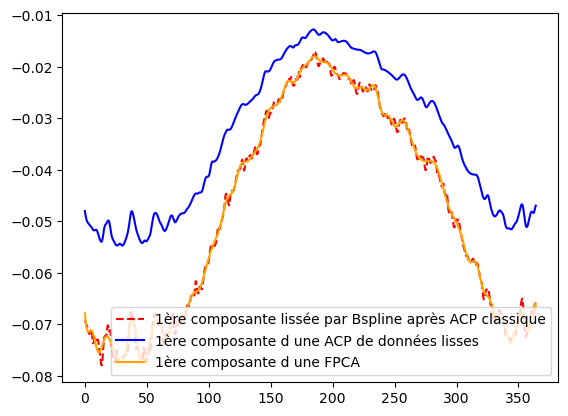

In [15]:
## Comparaison des 3 méthodes
                                                                                                                                             
plt.plot(t_interp, -acp_classique_Bspline1, 'r--', label = '1ère composante lissée par Bspline après ACP classique')
plt.plot(t_interp, -eig_cov_lisse[:,0], label = '1ère composante d une ACP de données lisses', color = 'blue')
plt.plot(t_interp, fpca.components_(t_interp)[0], label = '1ère composante d une FPCA', color = 'orange')
plt.legend()
plt.show()

# ACP fonctionnelle sur les données CD4

Tiré de l'étude MACS (Multicenter AIDS Cohort Study), l'ensemble de données sur la numération des cellules CD4 recueille le nombre de cellules CD4 par millilitre de sang de $N = 366$ participants. Les cellules CD4 sont un type particulier de globules blancs et sont des composants clés du système immunitaire. Le VIH attaque les cellules CD4 dans le sang du patient. Le nombre de cellules CD4 peut donc être considéré comme une mesure de la progression de la maladie. Pour cet ensemble de données, le nombre de cellules CD4 est mesuré environ deux fois par an et centré sur le moment de la séroconversion, qui est le moment où le VIH devient détectable. Pour chaque individu, le nombre de mesures varie de 1 à 11 sur une période de 18 mois avant et 42 mois après la séroconversion. Les points d'échantillonnage sont différents d'une observation à l'autre.

In [16]:
import pandas as pds
cd4 = pds.read_csv('cd4.csv', index_col=0)
all_argvals = cd4.columns.astype(np.int64)
argvals = {idx:np.array(all_argvals[~np.isnan(row)]) for idx, row in enumerate(cd4.values)}
values = {idx:row[~np.isnan(row)] for idx, row in enumerate(cd4.values)}
nb_patients = len(argvals)

Nous supprimons les patients qui ont un nombre d'observations $\leq 3$.

In [17]:
patients_out = []

for i in np.arange(nb_patients):
    if len(argvals[i]) < 4:
        del argvals[i]
        del values[i]
        patients_out.append(i)

patients = np.arange(nb_patients)
patients = np.delete(patients, patients_out)

nb_patients = len(patients)

**Exercice:** Afficher les observations des 20 premiers patients.

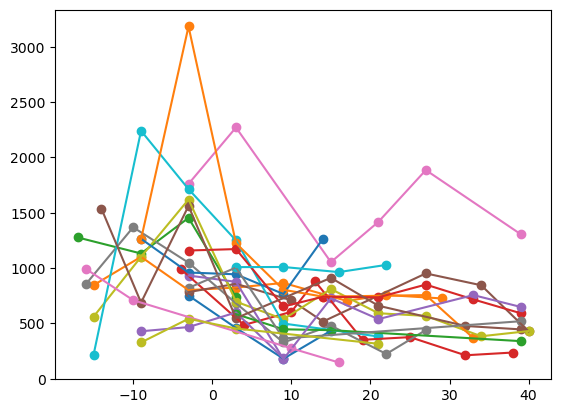

In [18]:
for i, pat in enumerate(patients[:20]):
    plt.scatter(argvals[pat], values[pat])
    plt.plot(argvals[pat], values[pat])

In [19]:
# On calcule [min_temps, max_temps], l'intervalle maxixal de points d'échantillonage, tout patient confondu.

min_temps = np.min(argvals[patients[0]])
max_temps = np.max(argvals[patients[0]])

for i, pat in enumerate(patients):
    a = np.min(argvals[pat])
    min_temps = np.min((a, min_temps))
    
    b = np.max(argvals[pat])
    max_temps = np.max((b, max_temps))

**Exercice:** Approcher les observations par des Bpline, sur l'intervalle maximal des temps d'observations des patients, en interpolant sur ```temps = np.linspace(min_temps, max_temps, 100)```.

/Users/elsacazelles/anaconda3/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:505: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


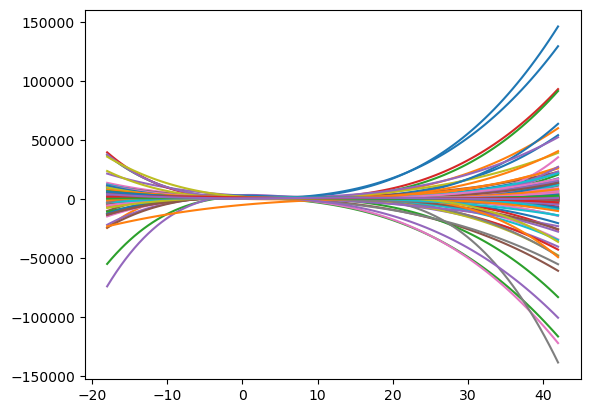

In [20]:
temps = np.linspace(min_temps, max_temps, 100)
cd4_lisse = np.zeros((nb_patients,100))

for i, pat in enumerate(patients):
    nn, c, k = splrep(argvals[pat], values[pat], s = 70)
    B = BSpline(nn, c, k)
    cd4_lisse[i,:] = B(temps)
    
plt.plot(temps,cd4_lisse.T)
plt.show()

Que remarquez-vous? Et qu'en déduisez-vous?

**Exercice:** Refaire une approximation par Bspline sans extrapoler en dehors de l'enveloppe convexe du support des fonctions (voir les paramètres de la fonction BSpline).

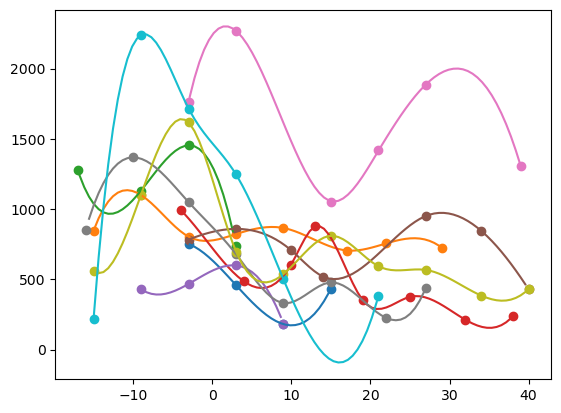

In [21]:
for i, pat in enumerate(patients):
    nn, c, k = splrep(argvals[pat], values[pat], k = 3, s = 20)
    B = BSpline(nn, c, k, extrapolate = False)
    cd4_lisse[i,:] = B(temps)
plt.plot(temps,cd4_lisse[:10,:].T)

for i, pat in enumerate(patients[:10]):
    plt.scatter(argvals[pat], values[pat])
plt.show()

**Remarque:** Il est primordial que les fonctions aient une base commune afin de pouvoir les comparer!

Nous utiliserons une base de Fourier ici.

In [22]:
from skfda.representation.basis import FourierBasis
from skfda.representation.basis import FDataBasis

nb_basis = 3
basis = FourierBasis(domain_range = (min_temps, max_temps), n_basis = nb_basis)


In [23]:
## On calcule les coefficients de chaque courbe dans la base de Fourier

basis_coeff = np.zeros((nb_patients,nb_basis))
for i, pat in enumerate(patients):
    aa = FDataBasis.from_data(values[pat], grid_points=argvals[pat], basis=basis)
    basis_coeff[i,:] = aa.coefficients

**Exercice:** En utilisant la fonction ```FDataBasis``` tracer les courbes dans la base de Fourier, puis tracer les deux premières composantes principales en utilisant la fonction ```FPCA``` de ```skfda.preprocessing.dim_reduction```.


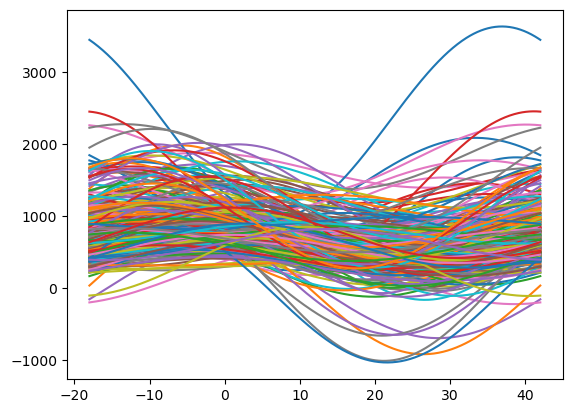

In [24]:
data = FDataBasis(basis, basis_coeff)
data.plot()
plt.show()

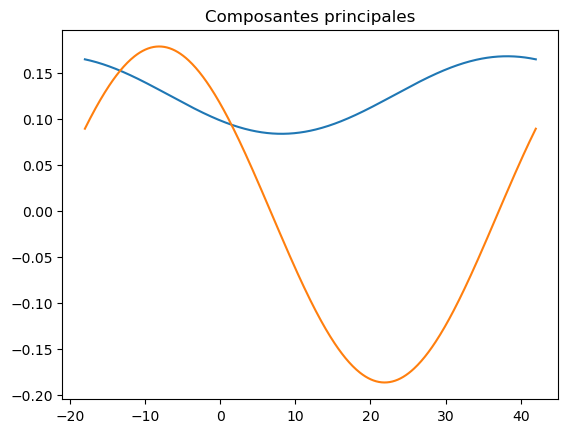

In [25]:
fpca = FPCA(n_components=2)
fpca.fit(data)
fpca.components_.plot()
plt.title('Composantes principales')
plt.show()

**Exercice:** tracer les projections des données sur les deux premières composantes principales.

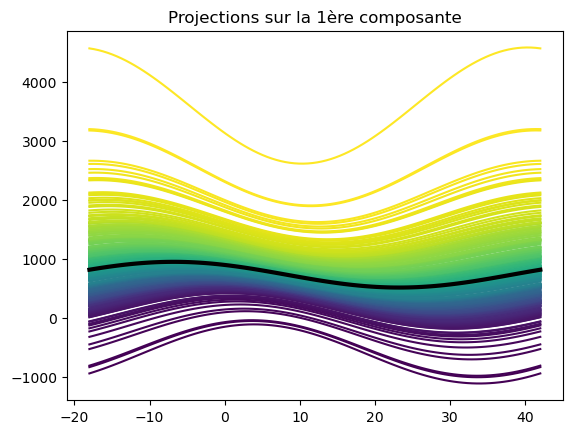

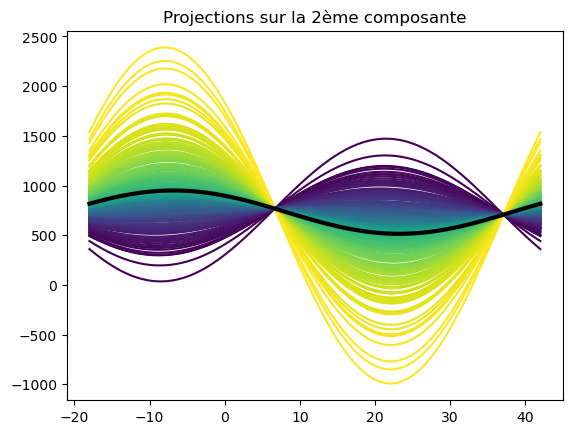

In [26]:
comp = fpca.components_(temps)
projection = np.dot(data(temps)[:,:,0]-np.mean(data(temps)[:,:,0],0),comp)
map2 = matplotlib.colormaps['viridis'].resampled(nb_patients)


## Première composante
comp1_proj = np.zeros((nb_patients,len(temps)))
I1 = np.argsort(projection[:,0,0])
for i in np.arange(nb_patients):
    comp1_proj[i,:] = fpca.mean_(temps)[0,:,0] + projection[I1[i],0,0]*comp[0,:,0]
    plt.plot(temps,comp1_proj[i,:],color = map2(i))
plt.plot(temps,fpca.mean_(temps)[0,:,0],linewidth= 3, color = 'black')
plt.title('Projections sur la 1ère composante')
plt.show()

## Deuxième composante
comp2_proj = np.zeros((nb_patients,len(temps)))
I2 = np.argsort(projection[:,1,0])
for i in np.arange(nb_patients):
    comp2_proj[i,:] = fpca.mean_(temps)[0,:,0] + projection[I2[i],1,0]*comp[1,:,0]
    plt.plot(temps,comp2_proj[i,:],color = map2(i))
plt.plot(temps,fpca.mean_(temps)[0,:,0],linewidth= 3, color = 'black')
plt.title('Projections sur la 2ème composante')
plt.show()

